In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
from datetime import datetime
from collections import deque
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler 
import math
import time
from datetime import date
import random
import matplotlib. pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import datetime as dt

In [18]:
train_data = pd.read_csv("train.csv", sep = ",")
train_data = pd.DataFrame(train_data, copy = 1)
test_data = pd.read_csv("test.csv", sep = ",")
test = test_data.copy()
test_data = pd.DataFrame(test_data, copy = 1)

In [19]:
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime) # Pickups
# data['dropoff_datetime'] = pd.to_datetime(data.dropoff_datetime) # Drop-offs
train_data['pickup_date'] = train_data['pickup_datetime'].dt.date # Extract date
train_data['pickup_time'] = train_data['pickup_datetime'].dt.time # Extract time
train_data['pickup_hour'] = train_data['pickup_datetime'].dt.hour # Extract hour
train_data['pickup_weekday'] = train_data['pickup_datetime'].dt.dayofweek # Extract day of week
# train_data.drop(['pickup_datetime'], axis = 1, inplace = True)
train_data.drop(['dropoff_datetime'], axis = 1, inplace = True)
# train_data.drop(['id'], axis = 1, inplace = True)
# train_data.drop(['vendor_id'], axis = 1, inplace = True)

test_data['pickup_datetime'] = pd.to_datetime(test_data.pickup_datetime)
test_data['pickup_date'] = test_data['pickup_datetime'].dt.date # Extract date
test_data['pickup_time'] = test_data['pickup_datetime'].dt.time # Extract time
test_data['pickup_hour'] = test_data['pickup_datetime'].dt.hour # Extract hour
test_data['pickup_weekday'] = test_data['pickup_datetime'].dt.dayofweek # Extract day of week
# test_data.drop(['pickup_datetime'], axis = 1, inplace = True)

# test_data.drop(['dropoff_datetime'], axis = 1, inplace = True)
test_data.drop(['id'], axis = 1, inplace = True)
test_data.drop(['vendor_id'], axis = 1, inplace = True)

In [20]:
# fonction pour calculer les distances à vol d'oiseau

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

# les distances pour Manhattan peuvent être assimiliées à des déplacements simples (on utilise la distance de Manhattan)
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
# train_data.loc[:, 'distance_haversine'] = haversine_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)

train_data.loc[:, 'distance_manhattan'] = manhattan_distance(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_manhattan'] = manhattan_distance(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)

train_data.drop(train_data[train_data.trip_duration < 20].index, inplace=True)


train_data.loc[:,'speed'] = train_data['distance_manhattan'] / train_data['trip_duration'] * 3.6
train_data.drop(train_data[train_data.speed > 0.050].index, inplace=True)
train_data.drop(train_data[train_data.speed < 0.003].index, inplace=True)

# train_data.drop(train_data[train_data.trip_duration > 5000].index, inplace=True)
# train_data.drop(train_data[train_data.trip_duration < 10].index, inplace=True)

train_data.drop(train_data[train_data.distance_manhattan < 0.001].index, inplace=True)

train_data.drop(train_data[train_data.passenger_count == 0].index, inplace=True)
train_data.drop(['speed'], axis = 1, inplace = True)

In [21]:
coords = np.vstack((train_data[['pickup_latitude', 'pickup_longitude']].values,
                    train_data[['dropoff_latitude', 'dropoff_longitude']].values
#                     ,test[['pickup_latitude', 'pickup_longitude']].values,
#                     test[['dropoff_latitude', 'dropoff_longitude']].values
                   ))

pca = PCA().fit(coords)

# pca

In [22]:
train_data.loc[:, 'direction'] = bearing_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
test_data.loc[:, 'direction'] = bearing_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)

In [23]:
train_data.loc[:, 'distance_haversine'] = haversine_array(train_data['pickup_latitude'].values, train_data['pickup_longitude'].values, train_data['dropoff_latitude'].values, train_data['dropoff_longitude'].values)
test_data.loc[:, 'distance_haversine'] = haversine_array(test_data['pickup_latitude'].values, test_data['pickup_longitude'].values, test_data['dropoff_latitude'].values, test_data['dropoff_longitude'].values)

train_data.loc[:, 'center_latitude'] = (train_data['pickup_latitude'].values + train_data['dropoff_latitude'].values) / 2
train_data.loc[:, 'center_longitude'] = (train_data['pickup_longitude'].values + train_data['dropoff_longitude'].values) / 2
test_data.loc[:, 'center_latitude'] = (test_data['pickup_latitude'].values + test_data['dropoff_latitude'].values) / 2
test_data.loc[:, 'center_longitude'] = (test_data['pickup_longitude'].values + test_data['dropoff_longitude'].values) / 2

In [24]:
train_data.loc[:, 'avg_speed_h'] = 1000 * train_data['distance_haversine'] / train_data['trip_duration']
train_data.loc[:, 'avg_speed_m'] = 1000 * train_data['distance_manhattan'] / train_data['trip_duration']

train_data.loc[:, 'pickup_dt'] = (train_data['pickup_datetime'] - train_data['pickup_datetime'].min()).dt.total_seconds()
test_data.loc[:, 'pickup_dt'] = (test_data['pickup_datetime'] - test_data['pickup_datetime'].min()).dt.total_seconds()


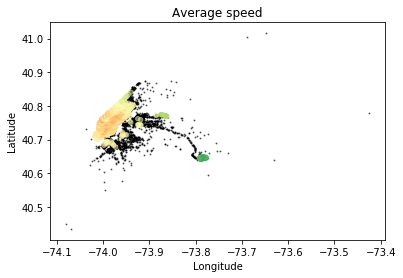

In [25]:
N = 100000
train_data.loc[:, 'pickup_lat_bin'] = np.round(train_data['pickup_latitude'], 3)
train_data.loc[:, 'pickup_long_bin'] = np.round(train_data['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train_data.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train_data.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train_data.pickup_longitude.values[:N], train_data.pickup_latitude.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
# ax.set_xlim(city_long_border)
# ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

train_data.loc[:, 'pickup_lat_bin'] = np.round(train_data['pickup_latitude'], 2)
train_data.loc[:, 'pickup_long_bin'] = np.round(train_data['pickup_longitude'], 2)
train_data.loc[:, 'center_lat_bin'] = np.round(train_data['center_latitude'], 2)
train_data.loc[:, 'center_long_bin'] = np.round(train_data['center_longitude'], 2)
train_data.loc[:, 'pickup_dt_bin'] = (train_data['pickup_dt'] // (3 * 3600))
test_data.loc[:, 'pickup_lat_bin'] = np.round(test_data['pickup_latitude'], 2)
test_data.loc[:, 'pickup_long_bin'] = np.round(test_data['pickup_longitude'], 2)
test_data.loc[:, 'center_lat_bin'] = np.round(test_data['center_latitude'], 2)
test_data.loc[:, 'center_long_bin'] = np.round(test_data['center_longitude'], 2)
test_data.loc[:, 'pickup_dt_bin'] = (test_data['pickup_dt'] // (3 * 3600))

In [26]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

train_data.loc[:, 'pickup_cluster'] = kmeans.predict(train_data[['pickup_latitude', 'pickup_longitude']])
train_data.loc[:, 'dropoff_cluster'] = kmeans.predict(train_data[['dropoff_latitude', 'dropoff_longitude']])
test_data.loc[:, 'pickup_cluster'] = kmeans.predict(test_data[['pickup_latitude', 'pickup_longitude']])
test_data.loc[:, 'dropoff_cluster'] = kmeans.predict(test_data[['dropoff_latitude', 'dropoff_longitude']])
t1 = dt.datetime.now()

In [122]:
test_data.columns

Index(['pickup_datetime', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_date', 'pickup_time', 'pickup_hour',
       'pickup_weekday', 'distance_manhattan', 'direction',
       'distance_haversine', 'center_latitude', 'center_longitude',
       'pickup_dt', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin',
       'center_long_bin', 'pickup_dt_bin', 'pickup_cluster',
       'dropoff_cluster'],
      dtype='object')

In [ ]:
# [ 'direction',
#        'distance_haversine', 'center_latitude', 'center_longitude',
#        'pickup_dt', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin',
#        'center_long_bin', 'pickup_dt_bin', 'pickup_cluster',
#        'dropoff_cluster',]

In [49]:
# train_data.drop(['pickup_hour'], axis = 1, inplace = True)
# train_data.drop(['pickup_weekday'], axis = 1, inplace = True)
# test_data.drop(['pickup_hour'], axis = 1, inplace = True)
# test_data.drop(['pickup_weekday'], axis = 1, inplace = True)

In [27]:
train_data.drop(['store_and_fwd_flag'], axis = 1, inplace = True)
# train_data.drop(['pickup_date'], axis = 1, inplace = True)
# train_data.drop(['pickup_time'], axis = 1, inplace = True)
train_data.drop(['pickup_datetime'], axis = 1, inplace = True)
train_data_tree_X = train_data[['direction',
       'distance_haversine', 'center_latitude', 'center_longitude',
       'pickup_dt', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin',
       'center_long_bin', 'pickup_dt_bin', 'pickup_cluster',
       'dropoff_cluster','distance_haversine','passenger_count','pickup_hour', 'pickup_weekday', 'distance_manhattan', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
train_data_tree_y = train_data['trip_duration']


# test_data.drop(['pickup_longitude'], axis = 1, inplace = True)
# test_data.drop(['pickup_latitude'], axis = 1, inplace = True)
# test_data.drop(['dropoff_longitude'], axis = 1, inplace = True)
# test_data.drop(['dropoff_latitude'], axis = 1, inplace = True)
test_data.drop(['store_and_fwd_flag'], axis = 1, inplace = True)
# test_data.drop(['pickup_date'], axis = 1, inplace = True)
# test_data.drop(['pickup_time'], axis = 1, inplace = True)
test_data.drop(['pickup_datetime'], axis = 1, inplace = True)
test_data_tree_X = test_data[['direction',
       'distance_haversine', 'center_latitude', 'center_longitude',
       'pickup_dt', 'pickup_lat_bin', 'pickup_long_bin', 'center_lat_bin',
       'center_long_bin', 'pickup_dt_bin', 'pickup_cluster',
       'dropoff_cluster','distance_haversine','passenger_count','pickup_hour', 'pickup_weekday', 'distance_manhattan', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
# test_data_tree_y = test_data['trip_duration']

In [165]:
train_data[['pickup_cluster',
       'dropoff_cluster']]

,pickup_cluster,dropoff_cluster
0,73,95
1,89,0
2,32,58
3,40,58
4,80,39
...,...,...
1458638,42,65
1458639,86,77
1458640,79,80
1458642,64,53


In [28]:
# As with other classifiers, DecisionTreeClassifier takes as input two arrays: an array X, sparse or dense, of size [n_samples, n_features] holding the training samples, and an array Y of integer values, size [n_samples], holding the class labels for the training samples:
from sklearn import tree
from sklearn.metrics import mean_squared_log_error

X=train_data_tree_X
X_test = test_data_tree_X
y=train_data_tree_y

reg = tree.DecisionTreeRegressor(max_leaf_nodes=100)
reg = reg.fit(X,y)
y_train_predict_tree=reg.predict(X)

print("La RMSE de l'arbre de régression",sqrt(mean_squared_error(y, y_train_predict_tree)))
print("La RMLSE de l'arbre de régression",sqrt(mean_squared_log_error(y, y_train_predict_tree)))

#from sklearn.model_selection import cross_validate


#X1, X2, y1, y2 = train_test_split(X, y, random_state=6)




#depth = []
#for i in range(1,2):
#    clf = tree.DecisionTreeRegressor(max_depth=90000+i*1000)
#    clf = clf.fit(X1,y1)
#    print(90000+i*1000," ",sqrt(mean_squared_error(clf.predict(X2), y2)))
#    depth.append((90000+i*1000,sqrt(mean_squared_error(clf.predict(X2), y2))))
#print (depth)



La RMSE de l'arbre de régression 334.1384229255774
La RMLSE de l'arbre de régression 0.3913443363152478


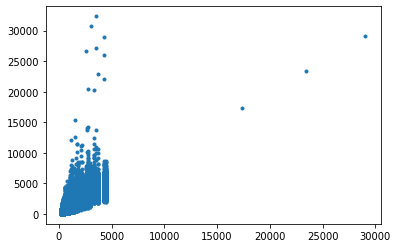

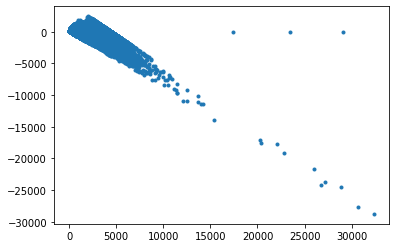

In [29]:
mpl.rcParams['agg.path.chunksize'] = 10000
plt.plot(y_train_predict_tree,y,'.')
plt.show()
plt.plot(y,y_train_predict_tree-y,'.')
plt.show()

In [30]:
y_test_predict_tree=reg.predict(X_test)

In [31]:
my_submission = pd.DataFrame({'id': test.id, 'trip_duration': y_test_predict_tree})
my_submission.to_csv('submission_tree.csv', index=False)